# Notes on Computing the Rollout Acquisition Function
## Considerations
- Incorporate control variates for variance reduction on rollout acquisition function
- Give further consideration for the construction of arbitrary kernels and maintaining which hyperparameters belong to which kernels. I think we can borrow from the `Multi-Fidelity Bayesian Optimization` repository. I need to treat scaling of kernels as creating a kernel object with a single hyperparameter and multiply this `ScaleKernel` against the other kernel.

## What I Need to Do
- [ ] When solving the linear system with the LU decomposition, be careful how we handle pivots.

In [270]:
using Profile
using ProfileView
using Polynomials

All the necessary imports for our computations of interest

In [271]:
include("../bayesian_optimization.jl")
plotlyjs()

Plots.PlotlyJSBackend()

## Basic Setup

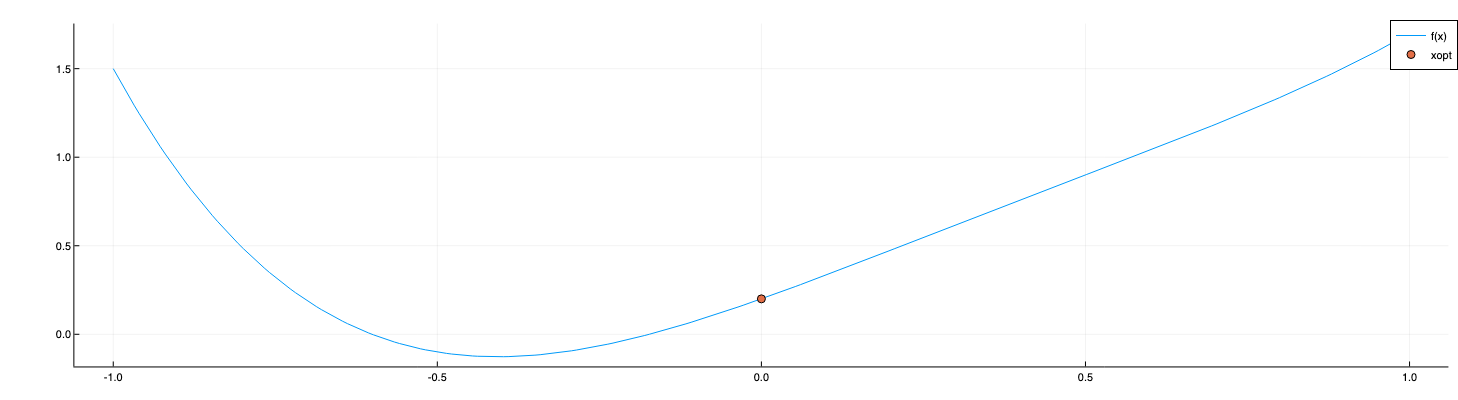

In [272]:
# Visualize 1D test function
# testfn = TestQuadratic1D()
using ForwardDiff

coefficients = [0.8, -1.2, 0.6, 1.3, 0.2]

# Polynomial function
function mypolynomial(x::AbstractVector)
    sum(coefficients[i] * x[1]^(length(coefficients) - i) for i in 1:length(coefficients))
end

# Gradient of the polynomial function
function grad_polynomial(x::AbstractVector)
    ForwardDiff.gradient(mypolynomial, x)[1]  # Computes the gradient
end

# Instantiate the TestFunction
testfn = TestFunction(1, [-1.0 1.0], ([0.0],), mypolynomial, grad_polynomial)

tplot(testfn)

In [286]:
lbs, ubs = get_bounds(testfn)
domain = lbs[1]:.01:ubs[1]

-2.0:0.01:2.0

In [287]:
kernel = Matern52()
polynomial = PolynomialBasisFunction([
        x -> 1., x -> first(x), x -> first(x) ^ 2, x -> first(x)^3, x -> first(x)^4
])
polynomial = PolynomialBasisFunction([
        x -> 0.
])
ϵ = 0.
Σ = Matrix{Float64}(I(length(polynomial)))
# Σ = zeros(length(polynomial), length(polynomial))
N = 5
observation_noise = 1e-1
X = randsample(N, testfn.dim, lbs, ubs)
y = testfn(X) + observation_noise * randn(N);
sur = Surrogate(kernel, polynomial, X, y,
    decision_rule=EI(),
    observation_noise=observation_noise,
    capacity=N,
    ϵ=ϵ,
    Σref=Σ
)

Surrogate{RBF = RadialBasisFunction{Float64}}

In [288]:
m = length(sur.ϕ)
# M = [sur.K  sur.P;
#      sur.P' zeros(m, m)];
M = [sur.K  sur.P;
     sur.P' -ϵ*inv(Σ)];
M = M + observation_noise * I
F = lu(M)
w = F \ [y; zeros(m)]
d = w[1:N]
λ = w[N+1:end]

1-element Vector{Float64}:
 0.0

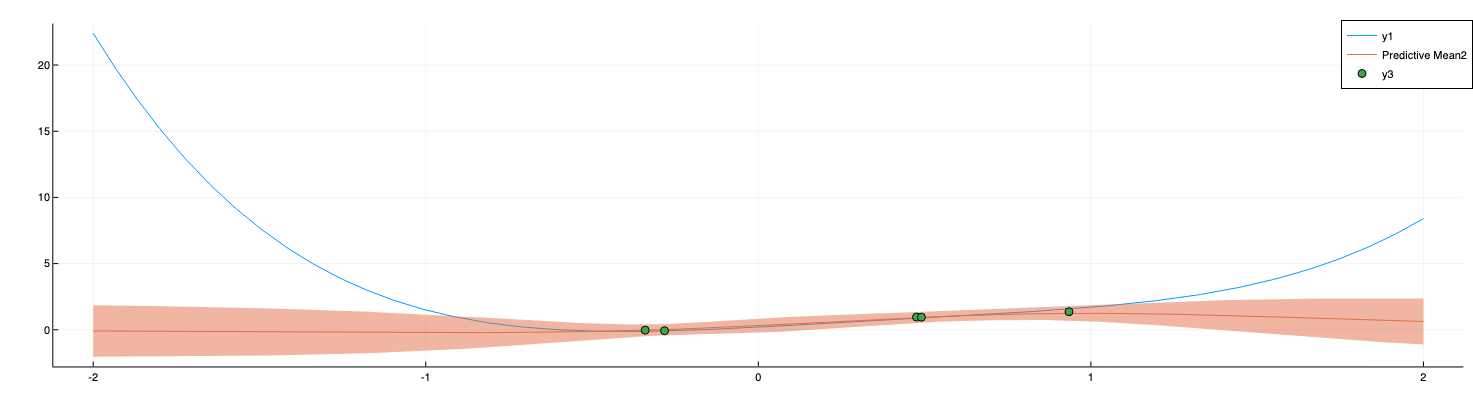

In [290]:
domain = 2lbs[1]:.01:2ubs[1]
μ = similar(domain)
μ2 = similar(domain)
σ = similar(domain)
σ2 = similar(domain)
EIx = similar(domain)

for (i, x) in enumerate(domain)
    KxX = eval_KxX(kernel, [x], X)
    Px = eval_basis(polynomial, [x])
    Kxx = eval_k(kernel, zeros(testfn.dim))
        
    v1 = [Px; KxX]
    v2 = [Px' KxX']
    H = [zeros(m, m) sur.P';
         sur.P        sur.K]
    # H = [-ϵ*inv(Σ)    sur.P';
    #      sur.P        sur.K]
    H = H + observation_noise * I
    
    μ[i] = dot(KxX, d) + dot(Px, λ)
    sx = sur([x], [0.])
    μ2[i] = sx.μ

    # s1 = H \ v2'
    # s1 = dot(v1, s1)
    # σ[i] = sqrt(Kxx - s1)
    σ2[i] = sx.σ
    EIx[i] = sx.αxθ
end

plot(domain, [testfn([x]) for x in domain])
# plot!(domain, μ, ribbons=σ, label="Predictive Mean")
plot!(domain, μ2, ribbons=2σ2, label="Predictive Mean2")
scatter!(X', y)

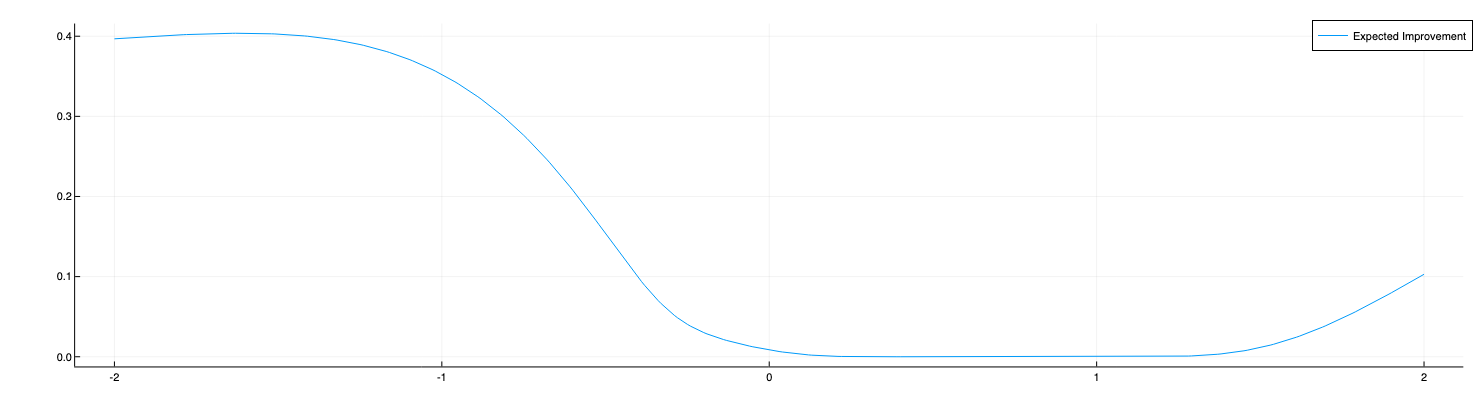

In [291]:
plot(domain, EIx, label="Expected Improvement")

In [231]:
optimize!(sur, lowerbounds=[.1], upperbounds=[3.])

In [52]:
f = Polynomial([0, 0, -.75, 0, 1])

# Define a function to evaluate each monomial term at a given x
function monomial_evaluation(poly, x)
    return [c * x^p for (p, c) in enumerate(coeffs(poly))]
end

monomial_evaluation (generic function with 1 method)

In [73]:
P = zeros(N, length(coeffs(f)))

for i in 1:N
    xs = first(X[:, i])
    P[i, :] = monomial_evaluation(f, xs)
end

In [74]:
Kxx = eval_KXX(kernel, X)
d = (Kxx + (1/ϵ) * P * P') \ y
λ = (1 / ϵ) * P' * d

5-element Vector{Float64}:
  0.0
  0.0
  0.15321992233366188
  0.0
 -0.057551071508470386

In [81]:
μ = similar(domain)
σ = similar(domain)
px_μs = similar(domain)
gp_μs = similar(domain)
left = nothing
right = nothing
M = nothing

for (i, x) in enumerate(domain)
    kx = eval_KxX(kernel, [x], get_active_covariates(sur))
    gp_μ = dot(kx, d)
    gp_μs[i] = gp_μ
    # gp_μ = 0.
    px = monomial_evaluation(f, x)
    px_μ = dot(px, λ)
    px_μs[i] = px_μ
    # px_μ = 0.
    μ[i] = gp_μ + px_μ

    left = [px..., kx...]
    right = [px..., kx...]
    M = [ϵ*inv(Σ) px';
         px       eval_k(kernel, [0.])]
    σ[i] = left' * M * right
end

plot(domain, μ, label="Combined Model")
plot!(domain, px_μs, label="Parametric Component")
plot!(domain, gp_μs, label="GP Component")
scatter!(X', y)

LoadError: DimensionMismatch: mismatch in dimension 1 (expected 5 got 1)